# Rule-based Classification

In this notebook, we attempt a first classification of the different activities using a rule-based system.

We investigate the significance of features extracted from the anonymized video since the 3D model has problems when the target becomes too small (far from camera).
In this approach, we only focus on 2D keypoints extracted from the video as (x,y) coordinates.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
all_activities = ["S1_A", "S1_B", "S1_C", "S1_G", "S1_H", "S1_J", "S1_K"]
activities = ['walk', 'run', 'jump', 'wave', 'clap', 'wipe', 'squat']

2D keypoints are arranged in a tensor with shape (2398, 17, 2).
- 2398 = number of video frames
-   17 = number of joints identified by 3DVideoPose
-    2 = (x,y) coordinates, the origin (0,0) is the top left corner

This is the layout of the joints (the points form a skeleton with head, arms, and legs facing the camera):

<div>
<img src="./images/2d_skeleton.png" height="200px" />
</div>

## Temporal Analysis

The dataset contains the anonymized video traces of 7 activities, namely:

0. **A**: walking
1. **B**: running
2. **C**: jumping
3. **G**: wave hands
4. **H**: clapping
5. **J**: wiping
6. **K**: squatting

In [23]:
time_window = 15
num_angles = 8
X = np.empty((0, time_window, num_angles))
Y = np.empty(0)
dims = [0]

for idx, activity in enumerate(all_activities):
  features = np.load(f'data/features2d_{activity}.npy')
  feature_images = np.empty((0, time_window, num_angles))

  # TEST CODE FOR FOURIER ANALYSIS
  # myangle = np.fft.fft(features[:,6] - np.mean(features[:,6]))
  # plt.plot(myangle)
  # plt.xlim((-10, 1000))
  # plt.ylim((-1000, 1000))

  # Create time sequences of feature vectors
  for line in range(0, features.shape[0] - time_window, 15):
    feature_over_time = np.expand_dims(features[line:(line+time_window), ...], axis=0)
    feature_images = np.concatenate((feature_images, feature_over_time))

  labels = idx * np.ones((feature_images.shape[0]))

  print(f'{activity}: {feature_images.shape}')
  dims.append(dims[-1]+feature_images.shape[0])
  
  X = np.concatenate((X, feature_images))
  Y = np.concatenate((Y, labels))

S1_A: (159, 15, 8)
S1_B: (159, 15, 8)
S1_C: (159, 15, 8)
S1_G: (159, 15, 8)
S1_H: (159, 15, 8)
S1_J: (159, 15, 8)
S1_K: (159, 15, 8)


In [24]:
XX = np.zeros((len(X), 8))

for idx, sample in enumerate(X):
	tmp1 = np.abs(sample[:-1,]-sample[1:,])
	tmp1[tmp1 > 180] -= 180  # unwrapping
	tmp1 = np.mean(tmp1, axis=0)
	tmp2 = np.max(sample, axis=0) - np.min(sample, axis=0)
	tmp2[tmp2 > 180] -= 180  # unwrapping

	XX[idx, :] = np.concatenate([np.mean(tmp1.reshape(-1, 2), axis=1), np.mean(tmp2.reshape(-1, 2), axis=1)]) #forearm, upperleg, lowerleg 

XX.shape

(1113, 8)

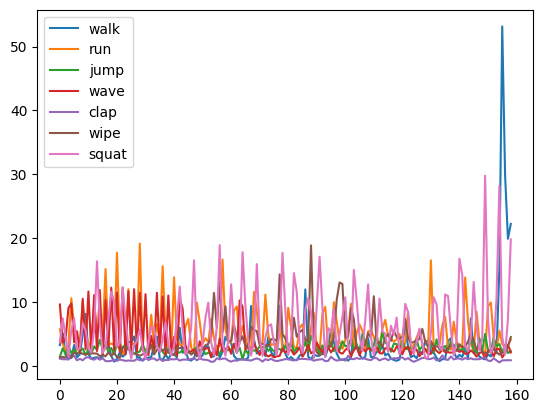

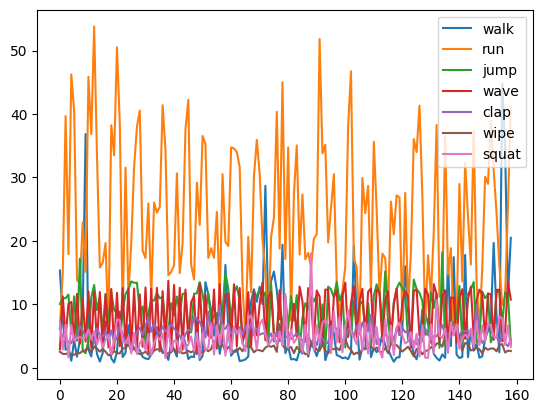

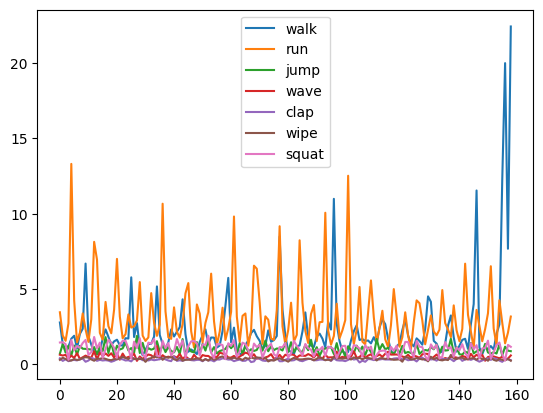

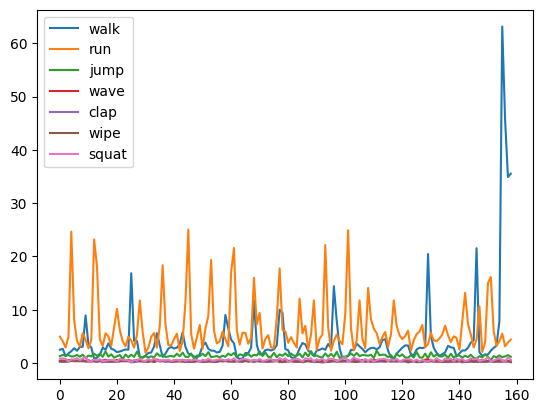

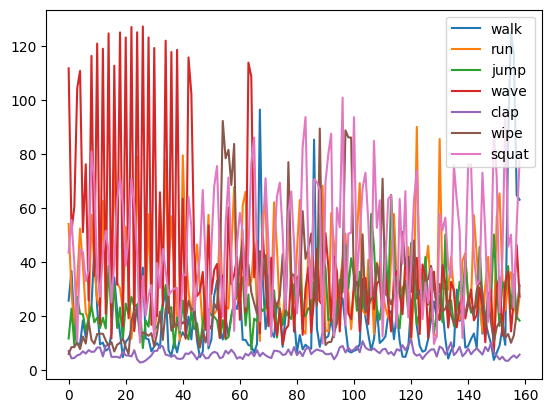

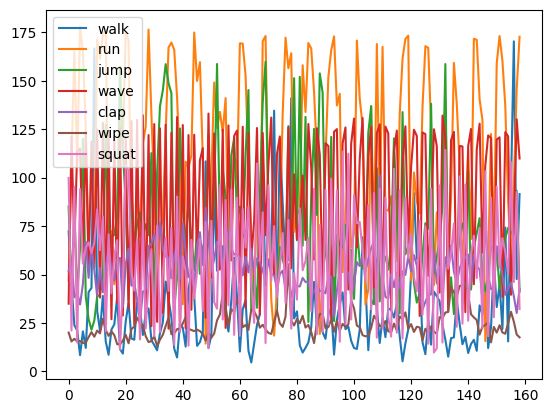

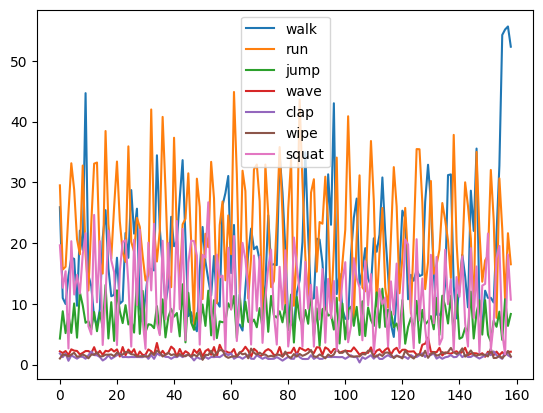

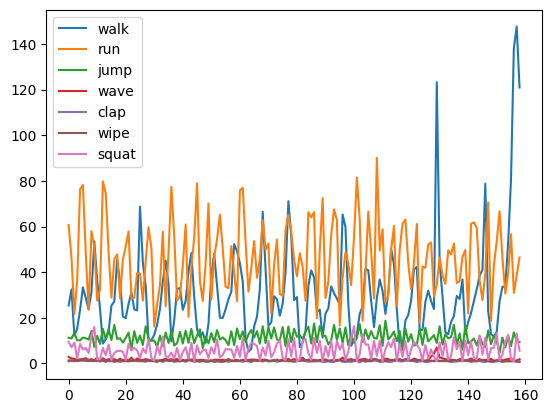

In [25]:
for feature in range(8):
	for idx in range(len(activities)):
		plt.plot(XX[dims[idx]:dims[idx+1], feature], label=activities[idx])

	plt.legend()
	plt.show()

## Causal analysis

In [4]:
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.lpcmci import LPCMCI


from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.cmisymb import CMIsymb

In [5]:
time_window = 15
time_step = 15
var_names = [['upperarms1', 'forearms1', 'upperleg1', 'lowerleg1'], ['upperarms2', 'forearms2', 'upperleg2', 'lowerleg2']]

In [ ]:
for idx, activity in enumerate(all_activities):
	features = np.load(f'data/features2d_{activity}.npy')
	feature_images = np.empty((0, time_window, 8))

	for line in range(0, features.shape[0] - time_window, time_step):
		feature_over_time = np.expand_dims(features[line:(line+time_window), ...], axis=0)
		feature_images = np.concatenate((feature_images, feature_over_time))

	tmp1 = np.abs(feature_images[:,:-1]-feature_images[:,1:])
	tmp1[tmp1 > 180] -= 180  # unwrapping
	tmp1 = np.mean(tmp1, axis=1)
	tmp2 = np.max(feature_images, axis=1) - np.min(feature_images, axis=1)
	tmp2[tmp2 > 180] -= 180  # unwrapping

	for i, tmp in enumerate([tmp1, tmp2]):
		data = np.mean(tmp.reshape(tmp.shape[0], -1, 2), axis=2)
		
		dataframe = pp.DataFrame(data, var_names=var_names[i])

		parcorr = ParCorr(significance='analytic')
		cmiknn = CMIknn()

		# pcmci = PCMCI(
		# 	dataframe=dataframe, 
		# 	cond_ind_test=parcorr,
		# 	verbosity=0)
		
		lpcmci = LPCMCI(
			dataframe=dataframe, 
			cond_ind_test=cmiknn,
			verbosity=0)
		
		results = lpcmci.run_lpcmci(tau_min=1, tau_max=3, pc_alpha=0.01)

		# Plot time series graph    
		tp.plot_time_series_graph(
			figsize=(6, 4),
			val_matrix=results['val_matrix'],
			graph=results['graph'],
			var_names=var_names[i],
			link_colorbar_label='MCI',
			)
		plt.title(activities[idx])
		plt.show()

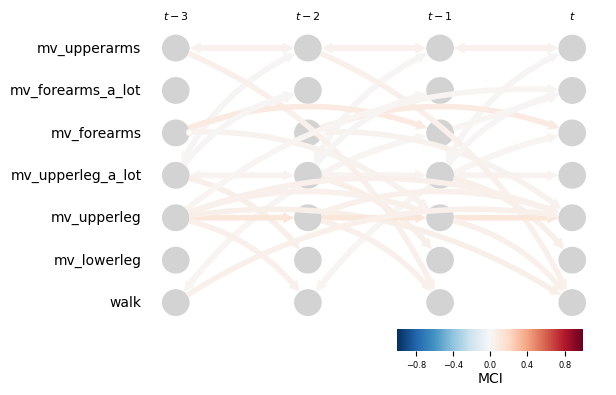

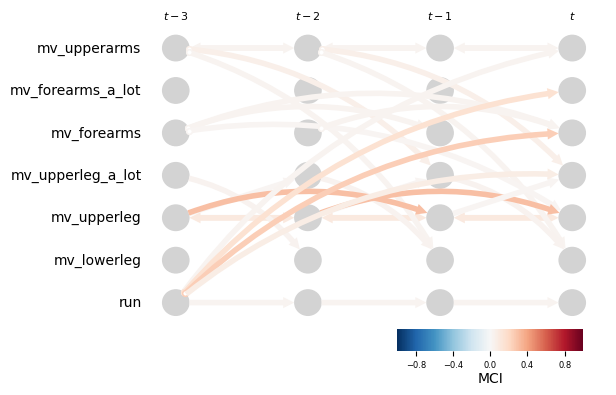

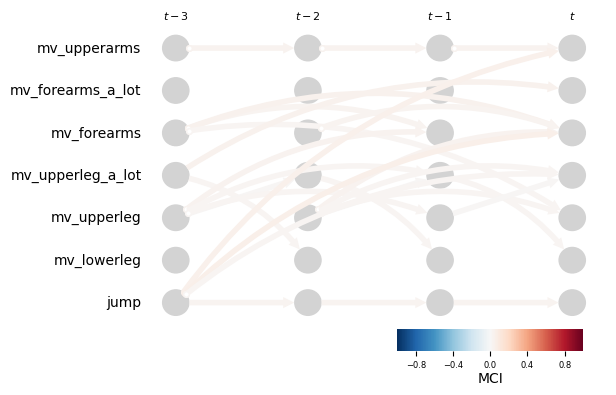

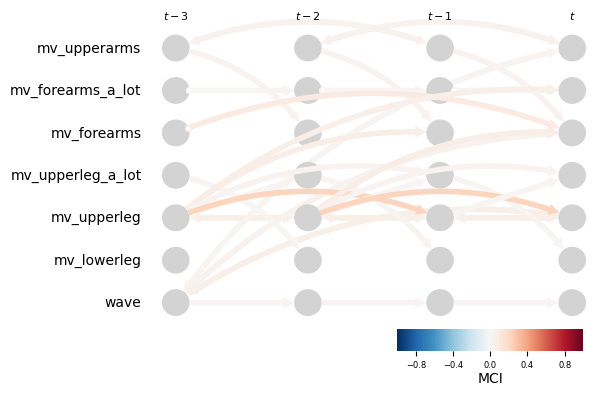

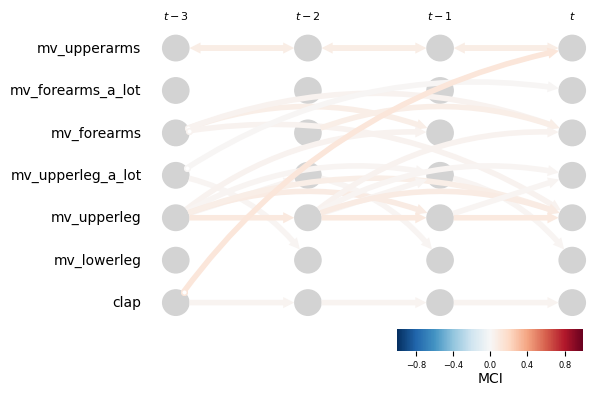

KeyboardInterrupt: 

In [15]:
activities = ['walk', 'wave']
all_activities = ["S1_A", "S1_G"]
propositions_names = ['mv_upperarms', 'mv_forearms_a_lot', 'mv_forearms','mv_upperleg_a_lot', 'mv_upperleg', 'mv_lowerleg']

propositions = np.empty((0, len(propositions_names)+1))

for idx, activity in enumerate(all_activities):
	features = np.load(f'data/features2d_{activity}.npy')
	feature_images = np.empty((0, time_window, 8))

	for line in range(0, features.shape[0] - time_window, time_step):
		feature_over_time = np.expand_dims(features[line:(line+time_window), ...], axis=0)
		feature_images = np.concatenate((feature_images, feature_over_time))

	tmp1 = np.abs(feature_images[:,:-1]-feature_images[:,1:]) # difference consecutive between frames
	tmp1[tmp1 > 180] -= 180  # unwrapping
	tmp1 = np.mean(tmp1, axis=1) # mean over time
	tmp1 = np.mean(tmp1.reshape(tmp1.shape[0], -1, 2), axis=2) # mean left and right
	# tmp2 = np.max(feature_images, axis=1) - np.min(feature_images, axis=1)
	# tmp2[tmp2 > 180] -= 180  # unwrapping
	# tmp2 = np.mean(tmp2.reshape(tmp2.shape[0], -1, 2), axis=2)


	tmp = np.zeros((feature_images.shape[0], len(propositions_names)))
	tmp[:, 0] = np.where(tmp1[:, 0] > 4, 1, 0)
	tmp[:, 1] = np.where(tmp1[:, 1] > 25, 1, 0)
	tmp[:, 2] = np.where(tmp1[:, 1] > 7, 1, 0)
	tmp[:, 3] = np.where(tmp1[:, 2] > 2, 1, 0)
	tmp[:, 4] = np.where(tmp1[:, 2] > 1, 1, 0)
	tmp[:, 5] = np.where(tmp1[:, 3] > 7, 1, 0)
	
	for i in range(len(activities)):
		if i == idx:
			propositions = np.concatenate((propositions, np.concatenate((tmp, np.ones((tmp.shape[0],1))), axis=1)))
		else:
			propositions = np.concatenate((propositions, np.concatenate((tmp, np.zeros((tmp.shape[0],1))), axis=1)))
	# features2 = np.concatenate((features2, np.concatenate((tmp2, labels), axis=1)))

for i, data in enumerate(propositions):

	dataframe = pp.DataFrame(data, var_names=propositions_names+[activities[i]])

	# dependency = ParCorr(significance='analytic')
	# dependency = CMIknn()
	dependency = CMIsymb()
	
	lpcmci = LPCMCI(
		dataframe=dataframe, 
		cond_ind_test=dependency,
		verbosity=0)
	
	results = lpcmci.run_lpcmci(tau_min=1, tau_max=3, pc_alpha=0.01)

	# Plot time series graph    
	tp.plot_time_series_graph(
		figsize=(6, 4),
		val_matrix=results['val_matrix'],
		graph=results['graph'],
		var_names=propositions_names+[activities[i]],
		link_colorbar_label='MCI',
		)
	plt.show()

In [6]:
propositions_names = ['mv_upperarms', 'mv_forearms_a_lot', 'mv_forearms','mv_upperleg_a_lot', 'mv_upperleg', 'mv_lowerleg']
features1 = np.empty((0, len(propositions_names)+len(all_activities)))
# features2 = np.empty((0, len(var_names[1])+len(all_activities)))

for idx, activity in enumerate(all_activities):
	features = np.load(f'data/features2d_{activity}.npy')
	feature_images = np.empty((0, time_window, 8))

	for line in range(0, features.shape[0] - time_window, time_step):
		feature_over_time = np.expand_dims(features[line:(line+time_window), ...], axis=0)
		feature_images = np.concatenate((feature_images, feature_over_time))

	tmp1 = np.abs(feature_images[:,:-1]-feature_images[:,1:]) # difference between consecutive frames
	tmp1[tmp1 > 180] -= 180  # unwrapping
	tmp1 = np.mean(tmp1, axis=1) # mean over time
	tmp1 = np.mean(tmp1.reshape(tmp1.shape[0], -1, 2), axis=2) # mean left and right
	# tmp2 = np.max(feature_images, axis=1) - np.min(feature_images, axis=1)
	# tmp2[tmp2 > 180] -= 180  # unwrapping
	# tmp2 = np.mean(tmp2.reshape(tmp2.shape[0], -1, 2), axis=2)

	labels = np.zeros((feature_images.shape[0], len(all_activities)))
	labels[:,idx] = 1
	tmp = np.zeros((feature_images.shape[0], len(propositions_names)))
	tmp[:, 0] = np.where(tmp1[:, 0] > 4, 1, 0)
	tmp[:, 1] = np.where(tmp1[:, 1] > 25, 1, 0)
	tmp[:, 2] = np.where(tmp1[:, 1] > 7, 1, 0)
	tmp[:, 3] = np.where(tmp1[:, 2] > 2, 1, 0)
	tmp[:, 4] = np.where(tmp1[:, 2] > 1, 1, 0)
	tmp[:, 5] = np.where(tmp1[:, 3] > 7, 1, 0)
	
	features1 = np.concatenate((features1, np.concatenate((tmp, labels), axis=1)))
	# features2 = np.concatenate((features2, np.concatenate((tmp2, labels), axis=1)))

for i, data in enumerate([features1]):#features2

	dataframe = pp.DataFrame(data, var_names=propositions_names+activities)

	# dependency = ParCorr(significance='analytic')
	# dependency = CMIknn()
	dependency = CMIsymb()

	# pcmci = PCMCI(
	# 	dataframe=dataframe, 
	# 	cond_ind_test=dependency,
	# 	verbosity=0)

	
	lpcmci = LPCMCI(
		dataframe=dataframe, 
		cond_ind_test=dependency,
		verbosity=0)
	
	results = lpcmci.run_lpcmci(tau_min=1, tau_max=3, pc_alpha=0.01)

	# q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=8, fdr_method='fdr_bh')
	# pcmci.print_significant_links(
	# 		p_matrix = q_matrix,
	# 		val_matrix = results['val_matrix'],
	# 		alpha_level = 0.01)
	# graph = pcmci.get_graph_from_pmatrix(p_matrix=q_matrix,
	# 			tau_min=0, tau_max=1, link_assumptions=None)
	# results['graph'] = graph

	# Plot time series graph    
	tp.plot_time_series_graph(
		figsize=(6, 4),
		val_matrix=results['val_matrix'],
		graph=results['graph'],
		var_names=propositions_names+activities,
		link_colorbar_label='MCI',
		)
	plt.show()

KeyboardInterrupt: 

## Rule-based classifier

Define a classication function based on some hardcoded rules derived from the analysis of the extracted data.


In [5]:
def classifier(features):
	'''features: is a 1D vector with 3 elements
		features[0]: forearm
		features[1]: upperleg
		features[2]: lowerleg
	'''

	# Define arbitrary thresholds (from manual data analysis)
	moves_lowerleg = features[2] > 30
	moves_upperleg_lot = features[1] > 20
	moves_upperleg = features[1] > 10
	moves_forearm_lot = features[0] > 16
	moves_forearm_medium = features[0] > 7
	moves_forearm_few = features[0] > 4 and features[0] < 7 


	if moves_lowerleg:
		if moves_forearm_lot:
			return 1  # run
		else:
			return 0  # walk
	elif moves_upperleg:
		if moves_upperleg_lot:
			return 6  # squat
		else:
			return 2  # jump
	else:
		if moves_forearm_medium:
			return 3  # wave
		else:
			if moves_forearm_few:
				return 4  # clap
			else:
				return 5  # wipe

In [6]:
predicted = np.zeros(Y.shape)

for idx, sample in enumerate(XX):
    predicted[idx] = classifier(sample)
    

In [7]:
report = classification_report(Y, predicted)
cm = confusion_matrix(Y, predicted)

In [8]:
print(report)

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      2308
         1.0       0.98      0.98      0.98      2308
         2.0       1.00      1.00      1.00      2308
         3.0       0.99      0.99      0.99      2310
         4.0       0.95      0.99      0.97      2310
         5.0       1.00      0.95      0.97      2308
         6.0       1.00      1.00      1.00      2310

    accuracy                           0.99     16162
   macro avg       0.99      0.99      0.99     16162
weighted avg       0.99      0.99      0.99     16162



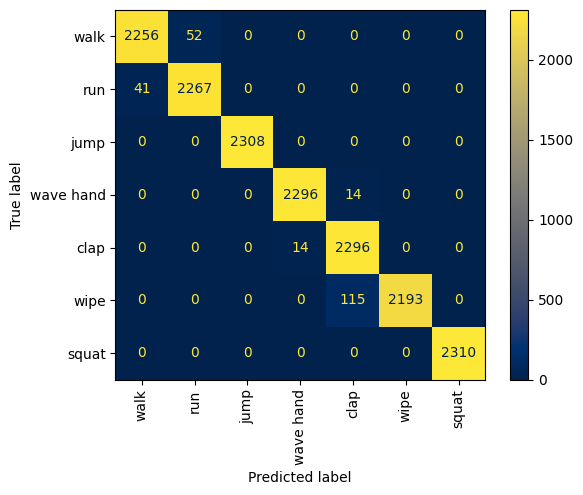

In [9]:
semantic_classes = ['walk', 'run', 'jump', 'wave hand', 'clap', 'wipe', 'squat']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=semantic_classes)
plot = disp.plot(cmap='cividis', xticks_rotation='vertical')